This is a customized code of wagenaars code given in the link:
https://github.com/wagenaartje/pinn4hcf

In [6]:
import torch
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

torch.manual_seed(5)
np.random.seed(5)

# Physical constants
gamma = 1.4
r_inf = 1.0
p_inf = 1.0
M_inf = 2.0
v_inf = 0.0
u_inf = math.sqrt(gamma*p_inf/r_inf)*M_inf

# Geometry
x_min = 0.0
x_max = 2
y_min = 0.0
y_max = 2.0
w_angle = math.radians(10)
w_start = 1

# Hyperparameters
num_ib = 750
num_r = 10000


''' Partial differential equations '''
def pde (state, coords):
    # Coordinates
    x = coords[0]
    y = coords[1]

    # State
    r = state[:, [0]]
    p = state[:, [1]]
    u = state[:, [2]]
    v = state[:, [3]]
    viscosity = state[:, [4]]**2
    
    rE = p/(gamma - 1) +0.5*r*(u**2+v**2)

    u1 = r
    u2 = r*u
    u3 = r*v
    u4 = rE

    f1 = r*u
    f2 = r*u*u+p
    f3 = r*u*v
    f4 = (rE+p)*u
    
    g1 = r*v
    g2 = r*v*u
    g3 = r*v*v + p
    g4 = (rE+p)*v
    
    f1_x = torch.autograd.grad(f1, x, grad_outputs=torch.ones_like(f1),create_graph=True)[0]
    f2_x = torch.autograd.grad(f2, x, grad_outputs=torch.ones_like(f2),create_graph=True)[0]
    f3_x = torch.autograd.grad(f3, x, grad_outputs=torch.ones_like(f3),create_graph=True)[0]
    f4_x = torch.autograd.grad(f4, x, grad_outputs=torch.ones_like(f4),create_graph=True)[0]

    g1_y = torch.autograd.grad(g1, y, grad_outputs=torch.ones_like(g1),create_graph=True)[0]
    g2_y = torch.autograd.grad(g2, y, grad_outputs=torch.ones_like(g2),create_graph=True)[0]
    g3_y = torch.autograd.grad(g3, y, grad_outputs=torch.ones_like(g3),create_graph=True)[0]
    g4_y = torch.autograd.grad(g4, y, grad_outputs=torch.ones_like(g4),create_graph=True)[0]

    u1_x = torch.autograd.grad(u1, x, grad_outputs=torch.ones_like(u1),create_graph=True)[0]
    u2_x = torch.autograd.grad(u2, x, grad_outputs=torch.ones_like(u2),create_graph=True)[0]
    u3_x = torch.autograd.grad(u3, x, grad_outputs=torch.ones_like(u3),create_graph=True)[0]
    u4_x = torch.autograd.grad(u4, x, grad_outputs=torch.ones_like(u4),create_graph=True)[0]

    u1_xx = torch.autograd.grad(u1_x, x, grad_outputs=torch.ones_like(u1_x),create_graph=True)[0]
    u2_xx = torch.autograd.grad(u2_x, x, grad_outputs=torch.ones_like(u2_x),create_graph=True)[0]
    u3_xx = torch.autograd.grad(u3_x, x, grad_outputs=torch.ones_like(u3_x),create_graph=True)[0]
    u4_xx = torch.autograd.grad(u4_x, x, grad_outputs=torch.ones_like(u4_x),create_graph=True)[0]

    u1_y = torch.autograd.grad(u1, y, grad_outputs=torch.ones_like(u1),create_graph=True)[0]
    u2_y = torch.autograd.grad(u2, y, grad_outputs=torch.ones_like(u2),create_graph=True)[0]
    u3_y = torch.autograd.grad(u3, y, grad_outputs=torch.ones_like(u3),create_graph=True)[0]
    u4_y = torch.autograd.grad(u4, y, grad_outputs=torch.ones_like(u4),create_graph=True)[0]

    u1_yy = torch.autograd.grad(u1_y, y, grad_outputs=torch.ones_like(u1_y),create_graph=True)[0]
    u2_yy = torch.autograd.grad(u2_y, y, grad_outputs=torch.ones_like(u2_y),create_graph=True)[0]
    u3_yy = torch.autograd.grad(u3_y, y, grad_outputs=torch.ones_like(u3_y),create_graph=True)[0]
    u4_yy = torch.autograd.grad(u4_y, y, grad_outputs=torch.ones_like(u4_y),create_graph=True)[0]

    r1 = f1_x + g1_y - viscosity * (u1_xx + u1_yy)
    r2 = f2_x + g2_y - viscosity * (u2_xx + u2_yy)
    r3 = f3_x + g3_y - viscosity * (u3_xx + u3_yy)
    r4 = f4_x + g4_y - viscosity * (u4_xx + u4_yy)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(f1),create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(f1),create_graph=True)[0]

    d=0.12*(abs(u_x)-u_x)  + 1+0.12*(abs(v_y)-v_y)

    return r1/d, r2/d, r3/d, r4/d

''' Model definition '''
# Generator
class Generator (torch.nn.Module):
    def __init__(self):
        super().__init__()
        t1=15

        torch.manual_seed(0)
        self.map = torch.nn.Sequential(
            torch.nn.Linear(2, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, t1), torch.nn.Tanh(),
            torch.nn.Linear(t1, 5)
        )

    def forward (self, a: tuple) -> torch.Tensor:
        # Force positive density and pressure
        res = self.map(torch.cat(a, 1))
        res[:,0] = torch.exp(res[:,0])
        res[:,1] = torch.exp(res[:,1])

        return res

def loss_slip (coords, thetas):
    for x in coords: x.requires_grad = True
    state = generator(coords)

    u = state[:, [2]]
    v = state[:, [3]]
    
    cos = torch.cos(thetas)
    sin = torch.sin(thetas)

    u_angle = u * cos + v * sin

    fb = (u_angle**2).mean()
    
    return fb


# Loss function for PDE
def loss_pde (coords):
    global mse_pde, res_r, res_p, res_u, res_v, mse_v

    for x in coords: x.requires_grad = True
    state = generator(coords)
    r1, r2, r3, r4 = pde(state, coords)


    f = (r1**2).mean() + \
        (r2**2).mean() + \
        (r3**2).mean() + \
        (r4**2).mean()
    
    mse_pde = f.item()
    res_r = (r1**2).mean().item()
    res_p = (r2**2).mean().item()
    res_u = (r3**2).mean().item()
    res_v = (r4**2).mean().item()

    f_v = (state[:,[4]]**2).mean()
    mse_v = f_v.item()
        
    return f, f_v

def loss_slip (coords, thetas):
    for x in coords: x.requires_grad = True
    state = generator(coords)
    x = coords[0]
    y = coords[1]

    r = state[:,[0]]
    p = state[:,[1]]
    u = state[:,[2]]
    v = state[:,[3]]
    
    cos = torch.cos(thetas)
    sin = torch.sin(thetas)
    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]

    cos = torch.cos(thetas)
    sin = torch.sin(thetas)

    p_theta = p_x * cos + p_y * sin
    # r_theta = r_x * cos + r_y * sin
    u_theta = u * cos + v * sin

    loss = (u_theta**2).mean() #+ \
            # (p_theta**2).mean()
            # (r_theta**2).mean()
    
    return loss

def loss_inlet (x_bc, u_bc):
    u_pred = generator(x_bc)
    
    loss = ((u_pred[:,0] - u_bc[0])**2).mean() + \
           ((u_pred[:,1] - u_bc[1])**2).mean() + \
           ((u_pred[:,2] - u_bc[2])**2).mean() + \
           ((u_pred[:,3] - u_bc[3])**2).mean()
    
    return loss

def loss_sym (coords, thetas):
    for x in coords: x.requires_grad = True
    state = generator(coords)
    x1 = coords[0]
    y1 = coords[1]


    u = state[:, [2]]
    v = state[:, [3]]
    p=state[:, [1]]
    p_x = torch.autograd.grad(p, x1, grad_outputs=torch.ones_like(p),create_graph=True)[0]
    p_y = torch.autograd.grad(p, y1, grad_outputs=torch.ones_like(p),create_graph=True)[0]
    cos = torch.cos(thetas)
    sin = torch.sin(thetas)
    pl=p_x+p_y



    # fb = (pl**2).mean()+(v**2).mean()
    fb =(v**2).mean()
    
    return fb


def evaluate ():
    global mse_bc
    optimizer.zero_grad()                     

    loss_r, loss_v = loss_pde(x_r)        
    loss_b = loss_sym(x_b, t_b)
    loss_l = loss_inlet(x_l, u_l)
    loss_c = loss_slip(x_w, t_w) 

    loss_bc = loss_c + loss_l + loss_b

    mse_bc = loss_bc.item()

    loss = loss_r + 1 * loss_bc + 1e-2 * loss_v
    loss.backward()

    return loss

if __name__ == '__main__':
    # Set up hardware 
    device = torch.device('cuda')
    torch.set_default_dtype(torch.float32)



    x_l = torch.full((num_ib, 1), x_min, device=device)
    y_l = torch.linspace(y_min, y_max, num_ib, device=device).reshape(-1,1)

    u_l = (r_inf, p_inf, u_inf, v_inf)

    # Top boundary
    x_t = torch.linspace(x_min, x_max, num_ib, device=device).reshape(-1,1)
    y_t = torch.full((num_ib, 1), y_max, device=device)

    t_t = torch.full((num_ib,1), -torch.pi/2,device=device)

    # Bottom boundary
    x_b = torch.linspace(x_min,w_start, num_ib+1, device=device)[:-1].reshape(-1,1)
    y_b = torch.full((num_ib, 1), y_min, device=device)

    t_b = torch.full((num_ib,1), torch.pi/2, device=device)

    # Wedge boundary
    x_w = torch.linspace(w_start, x_max, num_ib, device=device).reshape(-1,1)
    geom = lambda x:  (x-w_start)*math.tan(w_angle)
    y_w = y_min +geom(x_w)

    t_w = torch.full((num_ib,1), torch.pi/2 + w_angle, device=device)


    # Convert to tuples
    x_l = (x_l, y_l)
    x_t = (x_t, y_t)
    x_b = (x_b, y_b)
    x_w = (x_w, y_w)
    # x_r = (x_r[:,[0]], x_r[:,[1]])
    # x_test, u_test = reference(device)
     # print("Shape of tuple:", (rows, columns))
    # n1=101
    # [xp,yp] = np.meshgrid(np.linspace(x_min,x_max,n1),np.linspace(y_min,y_max,n1))
    # xf=xp.flatten()
    # yf=yp.flatten()
    # xin= np.vstack([xf,yf])
    # xin=np.transpose(xin)
    # t1=y_min  +geom(xin[:,0])
    # t1[np.isnan(t1)] = 0
    # mapping = xin[:,1] > t1
    # mapping1=xin[:,0]<w_start+0*xin[:,0]
    # mapping=mapping+mapping1
    # xin1 = xin[mapping,:]
    # x_test1 = torch.tensor(xin1[:,0], device=device, dtype=torch.float32)
    # y_test1 = torch.tensor(xin1[:,1], device=device, dtype=torch.float32)
    # x_test1=torch.reshape(x_test1,(-1,1))
    # y_test1=torch.reshape(y_test1,(-1,1))
    # # print(x_test1.shape)
    # x_test = (x_test1, y_test1)
    # x_r=x_test

    with open('fluent_mesh.dat', 'r') as file:
        lines = file.readlines()

# Skip the first line and split each line into a list of elements
    data = [line.strip().split() for line in lines[1:]]

# Convert the list of lists to a NumPy array
    data_in = np.array(data, dtype=float)  # Use dtype=float if your data is numeric

    x_in=data_in[:,1]
    y_in=data_in[:,2]
    x_test1 = torch.tensor(x_in, device=device, dtype=torch.float32)
    y_test1 = torch.tensor(y_in, device=device, dtype=torch.float32)
    x_test1=torch.reshape(x_test1,(-1,1))
    y_test1=torch.reshape(y_test1,(-1,1))
    x_test = (x_test1, y_test1)
    x_r=x_test

    # Set up models and optimizer
    generator = Generator().to(device)
    optimizer = torch.optim.LBFGS(generator.parameters(),lr=0.1)


    # Start looping
    epoch = 0
    start_time = time.time()
    lowest_loss = None
    lowest_loss_epoch = 0

    for i in range(1001):
        epoch_start_time = time.time() 

        # Optimize loss function
        if epoch > 0:
            loss = optimizer.step(evaluate)
        else:
            loss = evaluate()

        # Calculate L2 error
        

        # Print status
        print(f'Epoch: {epoch:4d} - Time: {time.time() - epoch_start_time:.2f} - MSE_r: {mse_pde:.2e} - MSE_v: {mse_v:.2e} - MSE_bc: {mse_bc:.2e} ')
        epoch += 1
        if mse_pde+mse_bc<1e-3:
                break

    u_pred = generator(x_test)    


Epoch:    0 - Time: 0.40 - MSE_r: 5.91e-02 - MSE_v: 5.68e-02 - MSE_bc: 5.22e+00 
Epoch:    1 - Time: 3.31 - MSE_r: 1.31e-02 - MSE_v: 1.95e-01 - MSE_bc: 1.22e-01 
Epoch:    2 - Time: 3.49 - MSE_r: 1.26e-02 - MSE_v: 1.13e-01 - MSE_bc: 6.58e-02 
Epoch:    3 - Time: 3.60 - MSE_r: 1.15e-02 - MSE_v: 8.71e-04 - MSE_bc: 3.57e-02 
Epoch:    4 - Time: 3.75 - MSE_r: 8.45e-03 - MSE_v: 6.85e-02 - MSE_bc: 2.14e-02 
Epoch:    5 - Time: 3.97 - MSE_r: 4.48e-03 - MSE_v: 1.22e-01 - MSE_bc: 1.80e-02 
Epoch:    6 - Time: 4.00 - MSE_r: 1.95e-03 - MSE_v: 1.37e-01 - MSE_bc: 1.58e-02 
Epoch:    7 - Time: 4.29 - MSE_r: 2.56e-03 - MSE_v: 1.14e-01 - MSE_bc: 1.31e-02 
Epoch:    8 - Time: 4.06 - MSE_r: 2.09e-03 - MSE_v: 1.11e-01 - MSE_bc: 1.18e-02 
Epoch:    9 - Time: 3.69 - MSE_r: 1.62e-03 - MSE_v: 1.00e-01 - MSE_bc: 1.08e-02 
Epoch:   10 - Time: 3.63 - MSE_r: 1.56e-03 - MSE_v: 7.97e-02 - MSE_bc: 9.00e-03 
Epoch:   11 - Time: 3.83 - MSE_r: 1.64e-03 - MSE_v: 6.37e-02 - MSE_bc: 7.49e-03 
Epoch:   12 - Time: 3.70 - M

In [7]:
r=u_pred[:,0]
p=u_pred[:,1]
u=u_pred[:,2]
v=u_pred[:,3]
x_test=torch.stack(x_test)
x_test=torch.reshape(x_test,(2,-1))
x_test=x_test.detach().cpu().numpy()
r=r.detach().cpu().numpy()
p=p.detach().cpu().numpy()
u=u.detach().cpu().numpy()
v=v.detach().cpu().numpy()
x_test1=x_test[0,:]
y_test1=x_test[1,:]

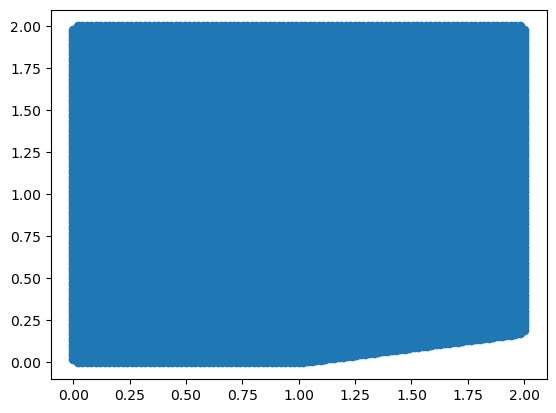

In [8]:
plt.scatter(x_test1,y_test1)

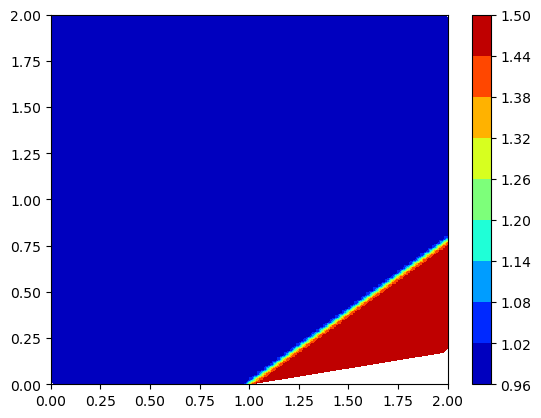

In [9]:
triang = Triangulation(x_test1, y_test1)
plt.tricontourf(triang, r, cmap='jet')
plt.colorbar()